In [1]:
#%pip install geopy
#%pip install geojson
#%pip install geopandas
#%pip install folium

In [2]:
import requests
import pandas as pd 
from geopy.geocoders import Bing
import re
import geojson
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import calendar

In [3]:
headers = {"token": 'cIqJOziMwStvUaByVOLBPeexHfHGwwuR'}

START_DATE = '2022-07-01'
END_DATE = '2022-10-31'

#station call
stations_url = f'https://www.ncdc.noaa.gov/cdo-web/api/v2/stations?datasetid=GHCND&datatypeid=TMIN&locationid=FIPS:27&startdate={START_DATE}&enddate={END_DATE}&limit=5'
stations_response = requests.get(stations_url, headers=headers)
stations_data = stations_response.json().get('results', [])

#weather call
all_weather_data = []
for station in stations_data:
    station_id = station['id']      
    weather_url = f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid={station_id}&datacategoryid=PRCP&units=metric&datacategoryid=TEMP&datatypeid=TMAX&datatypeid=TMIN&datatypeid=PRCP&startdate={START_DATE}&enddate={END_DATE}&limit=1000'
    weather_response = requests.get(weather_url, headers=headers)
    weather_data = weather_response.json().get('results', [])
    all_weather_data.extend(weather_data)

#put data from json into tabular format
df_weather = pd.DataFrame(all_weather_data)
df_stations = pd.DataFrame(stations_data)


In [4]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1513 non-null   object 
 1   datatype    1513 non-null   object 
 2   station     1513 non-null   object 
 3   attributes  1513 non-null   object 
 4   value       1513 non-null   float64
dtypes: float64(1), object(4)
memory usage: 59.2+ KB


In [5]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   elevation      5 non-null      float64
 1   mindate        5 non-null      object 
 2   maxdate        5 non-null      object 
 3   latitude       5 non-null      float64
 4   name           5 non-null      object 
 5   datacoverage   5 non-null      float64
 6   id             5 non-null      object 
 7   elevationUnit  5 non-null      object 
 8   longitude      5 non-null      float64
dtypes: float64(4), object(5)
memory usage: 488.0+ bytes


In [6]:
#function to get season from Date
def get_season(date):
    date = pd.to_datetime(date)
    m = date.month
    d = date.day
    if (m > 3 or (m == 3 and d >= 20)) and (m < 6 or (m == 6 and d < 21)):
        return 'Spring'
    if (m > 6 or (m == 6 and d >= 21)) and (m < 9 or (m == 9 and d < 22)):
        return 'Summer'
    if (m > 9 or (m == 9 and d >= 22)) and (m < 12 or (m == 12 and d < 21)):
        return 'Autumn'
    else:
        return 'Winter'
        
#merge data frames together to then split apart date column into specified columns for target fields
merged_df = df_weather.merge(df_stations, left_on='station', right_on='id', how='left')
merged_df['year'] = pd.to_datetime(merged_df['date']).dt.year
merged_df['month'] = pd.to_datetime(merged_df['date']).dt.month
merged_df['day'] = pd.to_datetime(merged_df['date']).dt.day
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.strftime('%Y-%m-%d')
merged_df['season'] = merged_df['date'].apply(get_season)
TimeDimension = merged_df[['date', 'year', 'month', 'day', 'season']].drop_duplicates().reset_index(drop=True)

#Make the weather table. Covert tempuratures from Celcius and move decimal.
WeatherFact = merged_df.pivot_table(index=['date', 'station'], columns='datatype', values='value', aggfunc='first').reset_index()
WeatherFact['TMAX'] = (WeatherFact['TMAX'] *9/5) + 32
WeatherFact['TMIN'] = (WeatherFact['TMIN'] * 9/5) + 32
column_mapping = {
    'TMAX': 'Temp_MaxF',
    'TMIN': 'Temp_MinF',
    'PRCP': 'Precip_Ich'}
WeatherFact.rename(columns=column_mapping, inplace=True)

LocationDimension = merged_df[['station', 'name', 'latitude', 'longitude', 'elevation']].drop_duplicates().reset_index(drop=True)
LocationDimension.columns = ['station_id', 'station_name', 'latitude', 'longitude', 'elevation']

In [7]:
#function for reverse geocoding
def reverse_geocode_bing(lat, lng, api_key):
    geolocator = Bing(api_key=api_key)
    location = geolocator.reverse((lat, lng), exactly_one=True)
    if location:
        return location.address
    else:
        return None

#function to extract state        
def extract_state(address):
    match = re.search(r', ([A-Z]{2}) ', address) 
    return match.group(1) if match else None

#function to extract zipcode
def extract_zipcode(address):
    match = re.search(r'\b\d{5}\b', address) 
    return match.group(0) if match else None

# API call and extracting zipcode and state from address returned
bing_api_key = 'Amq1ydlY_c9Vdg8cGvgmvxlkqO1Oo3Nk-XeXgHB8FTv1DF_GJcae_vWvH0x1BpAp'
LocationDimension['Address'] = LocationDimension.apply(lambda row: reverse_geocode_bing(row['latitude'], row['longitude'], bing_api_key), axis=1)
LocationDimension['Zipcode'] = LocationDimension['Address'].apply(extract_zipcode)
LocationDimension['State'] = LocationDimension['Address'].apply(extract_state)
LocationDimension = LocationDimension.drop(columns=['Address'])

#Added in county to zipcode map
zip_to_county = {
    '56623': 'Koochiching',
    '56510': 'Norman',
    '22996': 'Marshall',
    '39113': 'Atkin',
    '56007': 'Freeborn'
}
LocationDimension['County'] = LocationDimension['Zipcode'].map(zip_to_county)
LocationDimension.head()


,station_id,station_name,latitude,longitude,elevation,Zipcode,State,County
0,GHCND:CA006020559,"BARWICK, MN US",48.6333,-93.9667,335.0,56623,MN,Koochiching
1,GHCND:USC00210018,"ADA, MN US",47.2991,-96.5161,276.5,56510,MN,Norman
2,GHCND:USC00210050,"AGASSIZ REFUGE, MN US",48.3005,-95.9816,348.1,22996,MN,Marshall
3,GHCND:USC00210059,"AITKIN 2 E, MN US",46.5257,-93.6674,370.3,39113,MN,Atkin
4,GHCND:USC00210075,"ALBERT LEA 3 SE, MN US",43.6064,-93.3019,374.9,56007,MN,Freeborn


In [8]:
TimeDimension.head()

,date,year,month,day,season
0,2022-07-01,2022,7,1,Summer
1,2022-07-02,2022,7,2,Summer
2,2022-07-03,2022,7,3,Summer
3,2022-07-04,2022,7,4,Summer
4,2022-07-05,2022,7,5,Summer


In [9]:
WeatherFact.head()

datatype,date,station,Precip_Ich,Temp_MaxF,Temp_MinF
0,2022-07-01,GHCND:CA006020559,0.0,71.60,45.50
1,2022-07-01,GHCND:USC00210018,0.0,82.94,53.96
2,2022-07-01,GHCND:USC00210050,0.8,73.04,53.06
3,2022-07-01,GHCND:USC00210059,0.0,78.08,53.06
4,2022-07-01,GHCND:USC00210075,1.0,84.02,64.94


In [10]:
#save down csv for data warehouse loading
LocationDimension.to_csv('LocationDimension.csv', index=False)
WeatherFact.to_csv('WeatherFact.csv', index=False)
TimeDimension.to_csv('TimeDimension.csv', index=False)

In [11]:
#fuction to create geojson based on latitude and longitude 
def df_to_geojson(df):
    features = []
    for _, row in df.iterrows():
        feature = {
            "type": "Feature",
            "properties": {
                "stationID": row["station_id"]
            },
            "geometry": {
                "type": "Point",
                "coordinates": [row["longitude"], row["latitude"]]
            }
        }
        features.append(feature)
        
    return {
        "type": "FeatureCollection",
        "features": features}

geojson_obj = df_to_geojson(LocationDimension)
with open("stations.geojson", "w") as file:
    geojson.dump(geojson_obj, file)

In [12]:
geodf = gpd.read_file('stations.geojson')

#make html from the geojson file
map = folium.Map(location=[geodf['geometry'].iloc[0].y, geodf['geometry'].iloc[0].x], zoom_start=6)
for idex, row in geodf.iterrows():
    folium.Marker(location=[row['geometry'].y, row['geometry'].x],
                  popup=row['stationID']).add_to(map)

map.save("map.html")

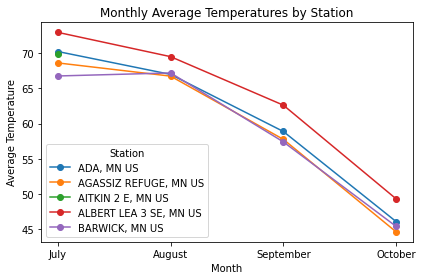

In [13]:
#Create total average by station crosstab and visualization
WeatherFact['TAVG'] = (WeatherFact['Temp_MaxF'] + WeatherFact['Temp_MinF']) / 2

df_merged = WeatherFact.merge(TimeDimension, left_on='date', right_on='date')
df_merged = df_merged.merge(LocationDimension, left_on='station', right_on='station_id')

ct = pd.crosstab(df_merged['month'], df_merged['station_name'], values=df_merged['TAVG'], aggfunc='mean')

month_names = [calendar.month_name[i] for i in ct.index]
ct.plot(kind='line', marker='o')
plt.title("Monthly Average Temperatures by Station")
plt.ylabel("Average Temperature")
plt.xlabel("Month")
plt.xticks(ticks=ct.index, labels=month_names)
plt.legend(title='Station')
plt.tight_layout()
plt.savefig("MATBS.png", transparent=True)
plt.show()


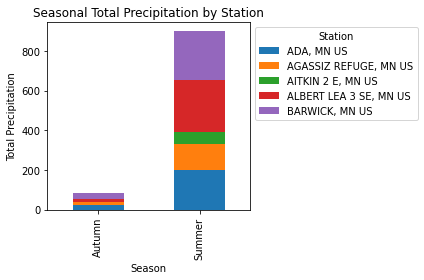

In [14]:
#create crosstab for Seasonal Percipitation by station and visual
df_merged = WeatherFact.merge(TimeDimension, left_on='date', right_on='date')
df_merged = df_merged.merge(LocationDimension, left_on='station', right_on='station_id')

ct = pd.crosstab(df_merged['season'], df_merged['station_name'], values=df_merged['Precip_Ich'], aggfunc='sum')

ct.plot(kind='bar', stacked=True)
plt.title("Seasonal Total Precipitation by Station")
plt.ylabel("Total Precipitation")
plt.xlabel("Season")
plt.legend(title='Station', bbox_to_anchor=(1., 1), loc='upper left')
plt.tight_layout()
plt.savefig("STPBS.png", transparent=True)
plt.show()


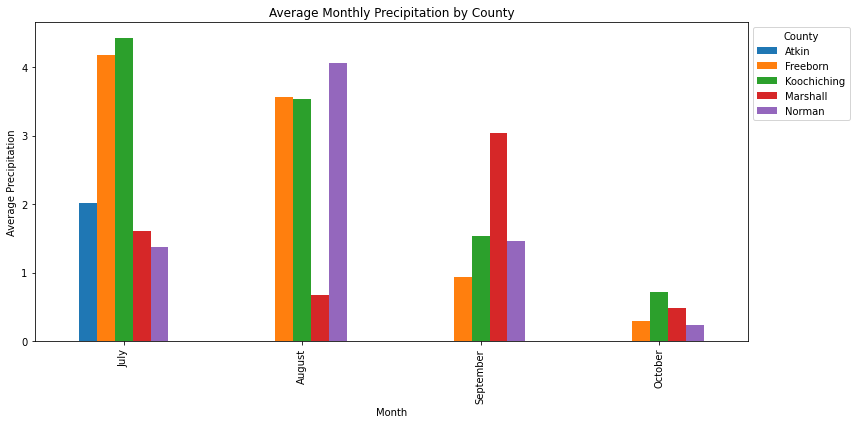

In [15]:
#Create Average monthly precipitation by County
df_merged = WeatherFact.merge(TimeDimension, left_on='date', right_on='date')
df_merged = df_merged.merge(LocationDimension, left_on='station', right_on='station_id')

avg_precip = df_merged.groupby(['month', 'County']).agg({'Precip_Ich': 'mean'}).reset_index()

pivot_avg_precip = avg_precip.pivot(index='month', columns='County', values='Precip_Ich')

pivot_avg_precip.index = pd.to_datetime(pivot_avg_precip.index, format='%m').month_name()

pivot_avg_precip.plot(kind='bar', figsize=(12, 6))
plt.title("Average Monthly Precipitation by County")
plt.ylabel("Average Precipitation")
plt.xlabel("Month")
plt.legend(title='County', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.savefig("AMPBC.png")
plt.show()
